## はじめに

このノートブックは、scikit-fdaのドキュメントのうち、[Functional Principal Component Analysis](https://fda.readthedocs.io/en/latest/auto_examples/plot_fpca.html#sphx-glr-auto-examples-plot-fpca-py)について解説したものです。

このドキュメントの記載のコードは、以下のライセンスにて提供されています。

In [1]:
# Author: Yujian Hong
# License: MIT

このノートでは、基底関数系の線型結合によって表現されたデータのことを関数データと記載します。

In [2]:
!python --version

Python 3.7.15


## ライブラリの準備

In [3]:
# 検証時点ではpipからだとFPCAのロードができなかったので、Githubから直接インストールした。
# https://github.com/GAA-UAM/scikit-fda/
!git clone https://github.com/GAA-UAM/scikit-fda.git
!pip install ./scikit-fda

Cloning into 'scikit-fda'...
remote: Enumerating objects: 19950, done.
remote: Counting objects: 100% (1701/1701), done.
remote: Compressing objects: 100% (655/655), done.
remote: Total 19950 (delta 1135), reused 1550 (delta 1046), pack-reused 18249
Receiving objects: 100% (19950/19950), 11.49 MiB | 12.17 MiB/s, done.
Resolving deltas: 100% (14674/14674), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./scikit-fda
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata 

In [4]:
# Google Colabだとエラーが出たので追加でインストールする。
!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 6.7 MB/s 
     |████████████████████████████████| 71 kB 7.1 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565119 sha256=7dae44c85c5d888f0c2170e9552056469fbb52ac0c652a033f5def3f06747274
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=a63197b41a1b8f2d336ce4e8a07bce002ea323c12b710b9ace29e7bae8ff5b4e
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


In [5]:
import matplotlib.pyplot as plt

import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial

## FPCAの実行結果

データセットを読み込みます。今回はサンプルに従い、Berkeley Growth Studyデータを使います。

少年39名、少女54名の1歳から18歳までの身長が記録されています。

データは`skfda.datasets.fetch_growth()`から取得できます。特にdataは[FDataGrid](https://fda.readthedocs.io/en/latest/modules/autosummary/skfda.representation.grid.FDataGrid.html)です。

FDataGridにはデータを図示する機能も付いているので可視化してみます。サンプルと同じように`plot`でもよいのですが、この時点ではデータは離散データのはずで、`scatter`の方が良いと思ったので今回はこちらで可視化しています。この方が、後で関数データ化した際に違いがイメージしやすいように思います。

以下のIssueに上がっているとおり、図は同じものが２つ出ていますが、気にしないでください。

https://github.com/GAA-UAM/scikit-fda/issues/237



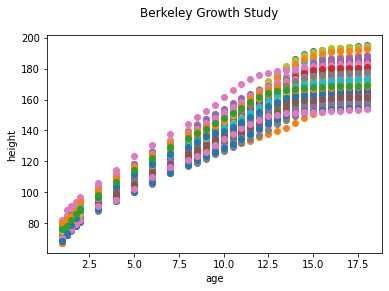

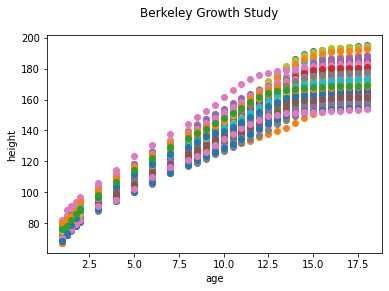

In [6]:
dataset = skfda.datasets.fetch_growth()
fd = dataset['data']
y = dataset['target']
fd.scatter()

In [7]:
type(fd)

skfda.representation.grid.FDataGrid

基底関数を使って関数データ化します。今回はB-スプライン関数を７本使います。`FDataGrid.to_basis`により、指定した基底関数を使った関数データへ変換することができます。

内部的には、指定した基底関数${\phi_k}$をどのように結合すれば元のデータが近似できるのか求めるために${c_k}$を計算しないといけませんが、scikit-fdaではこのAPIを使うことでとても簡単に計算することが可能です。便利です。

$$
f(x) = \sum_{k=1}^Kc_k\phi_k
$$

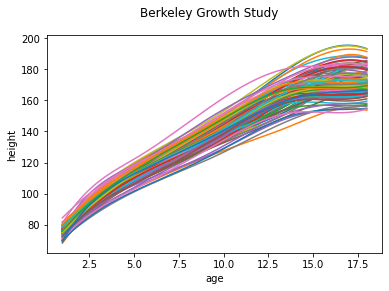

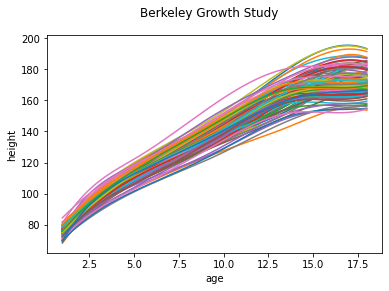

In [8]:
# B-スプライン関数のうち７本を基底関数として使う。
basis = skfda.representation.basis.BSpline(n_basis=7)
basis_fd = fd.to_basis(basis)
basis_fd.plot()

`basis`からは、どんなパラメータの基底関数になっているか確認することができます。

In [9]:
basis

BSpline(domain_range=((0.0, 1.0),), n_basis=7, order=4, knots=(0.0, 0.25, 0.5, 0.75, 1.0))

データが`FDataBasis`に変換されていることが分かります。

In [10]:
type(basis_fd)

skfda.representation.basis._fdatabasis.FDataBasis

In [11]:
basis_fd

FDataBasis(
    basis=BSpline(domain_range=((1.0, 18.0),), n_basis=7, order=4, knots=(1.0, 5.25, 9.5, 13.75, 18.0)),
    coefficients=[[ 81.62184377  95.32753609 122.2487525  142.51904585 184.48664294
      199.4720117  193.26470272]
     [ 76.82387771  94.30494976 113.90201189 141.02004067 150.21453901
      177.65529306 178.70330065]
     [ 77.58910292  90.54722502 111.01024139 129.36125539 155.59740349
      176.40598876 170.17572555]
     [ 74.58592798  97.30148012 111.46408202 139.36659537 160.75057757
      189.48452894 180.05249928]
     [ 74.34003046  85.38726311 107.13999049 130.25472739 157.51640746
      178.92214655 171.22214901]
     [ 77.08381416  89.94697808 114.54100512 133.60614578 157.71863811
      178.40595159 172.36170236]
     [ 73.13251635  89.67998806 113.02559752 137.90195028 149.94684293
      175.84140668 171.70970635]
     [ 75.05244064  95.6801746  116.61117871 138.66735411 174.66040512
      188.69631115 184.23025242]
     [ 76.89980835  98.95253797 106.23

FPCAを実行して、２つのFPCについて可視化してみます。

FPCAはそのためのAPIが実装されているので、それを使います。

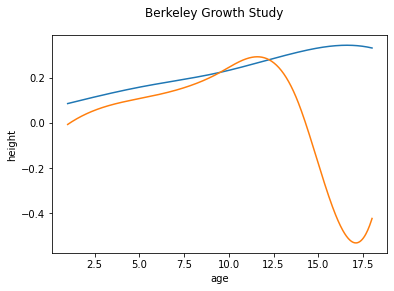

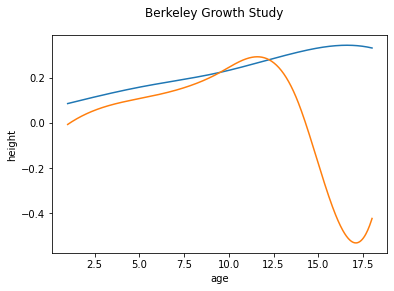

In [12]:
fpca = FPCA(n_components=2)
fpca.fit(basis_fd)
fpca.components_.plot()

ドキュメントの解説では、第一主成分関数は単純に標本の身長の平均を表しており、第二主成分関数は成長の傾向を表しているとしています。

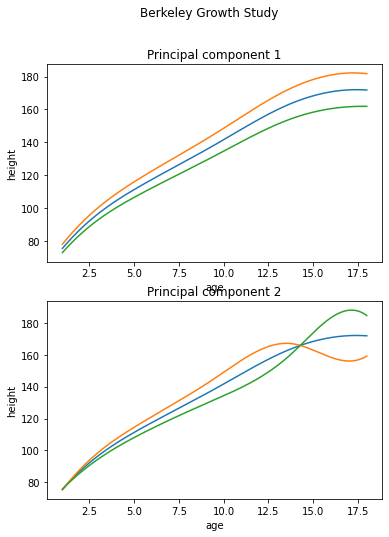

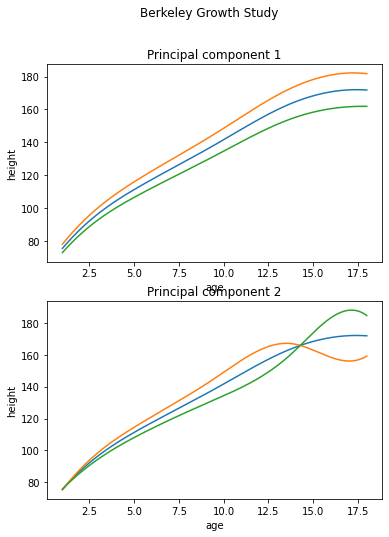

In [13]:
FPCAPlot(
    basis_fd.mean(),
    fpca.components_,
    factor=30,
    fig=plt.figure(figsize=(6, 2 * 4)),
    n_rows=2,
).plot()

同様の方法で第三主成分関数まで表示してみました。これも第二主成分関数と一緒で成長の傾向を表しているようにみえます。

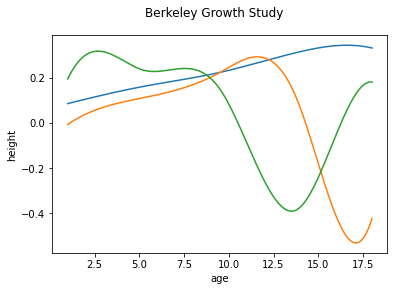

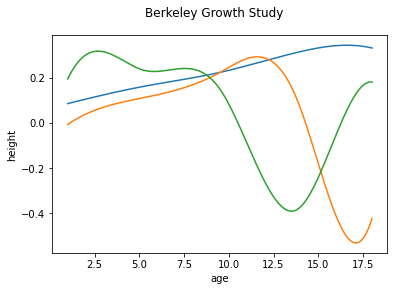

In [14]:
fpca = FPCA(n_components=3)
fpca.fit(basis_fd)
fpca.components_.plot()

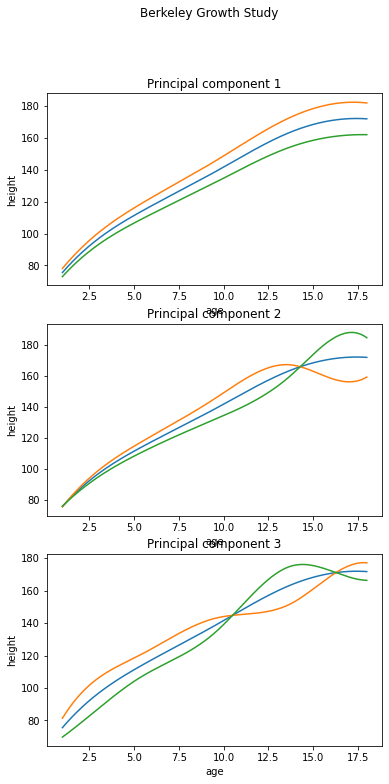

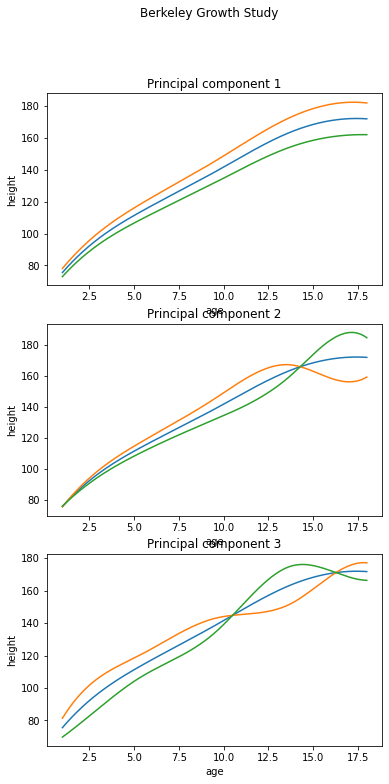

In [15]:
FPCAPlot(
    basis_fd.mean(),
    fpca.components_,
    factor=30,
    fig=plt.figure(figsize=(6, 3 * 4)),
    n_rows=3,
).plot()

使用する基底関数系の例として、フーリエ基底を使ったものも紹介されていました。

今回のデータは周期的なデータではないので、上手くはいきません。実際、B-スプライン基底を使った場合と比べて、関数データ化したデータが歪んでしまい、FPCAで取得した第一・第二主成分関数もまた、その傾向が表れています。

今回のようなデータはB-スプライン基底で関数データ化した方がいいことが分かります。

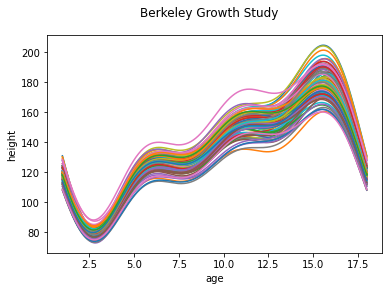

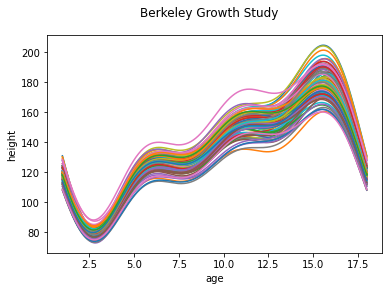

In [16]:
dataset = fetch_growth()
fd = dataset['data']
basis = skfda.representation.basis.Fourier(n_basis=7)
basis_fd = fd.to_basis(basis)
basis_fd.plot()

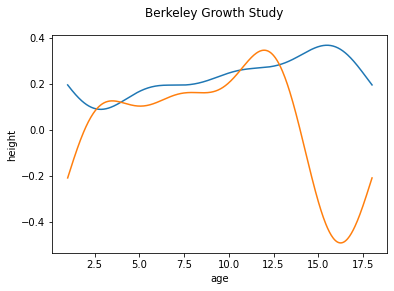

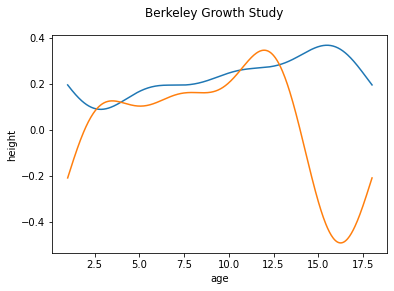

In [17]:
fpca = FPCA(n_components=2)
fpca.fit(basis_fd)
fpca.components_.plot()

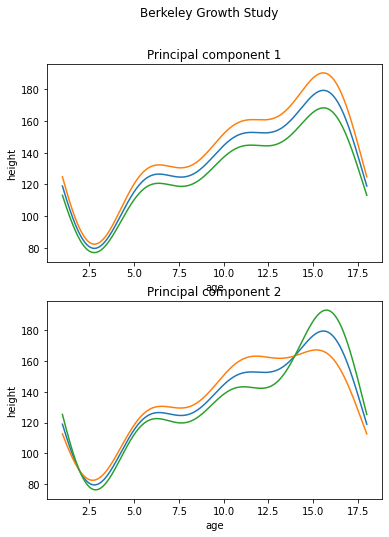

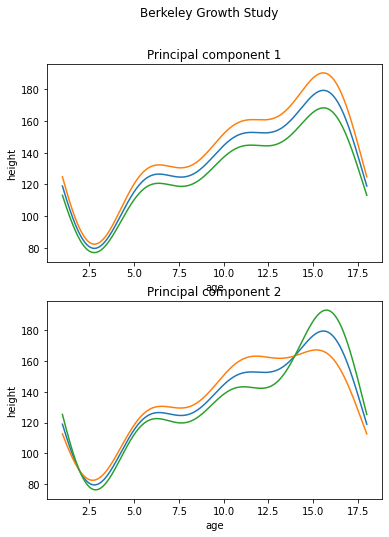

In [18]:
FPCAPlot(
    basis_fd.mean(),
    fpca.components_,
    factor=30,
    fig=plt.figure(figsize=(6, 2 * 4)),
    n_rows=2,
).plot()